# Galaxy Image Deconvolution

In this project, we are going to play with a very common task in astronomical image processing - **image deconvolution**. Due to nonideal effects of the atmosphere and telescope optics, the images captured by telescopes suffer from blurs, which can be described by the **point spread function (PSF)** of telescope. Removing those blurs is very crucial for astronomers to precisely uncover knowledge of the universe.

### Preparations

Download and import the packages we need in this project.

In [2]:
# %pip install numpy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift

Load the clean galaxy image (without blur and noise) and point spread function (PSF) of the telescope. For simplicity, these images are proviede for you. If you are interested in how those images are simulated, you can check out [this notebook](https://github.com/Lukeli0425/Galaxy-Deconv/blob/main/tutorials/image_simulation.ipynb).

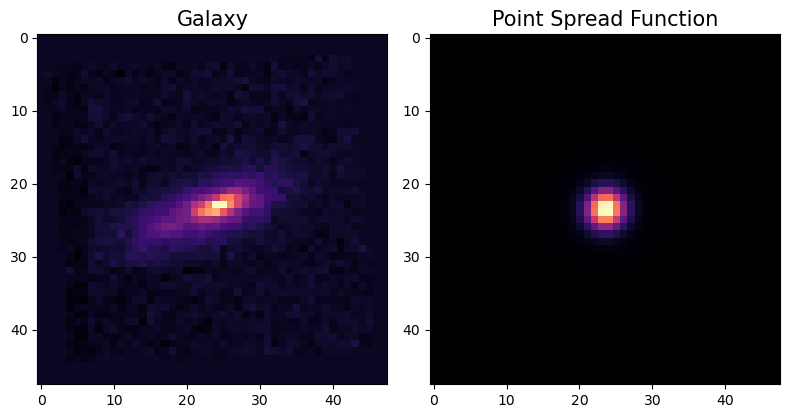

In [3]:
galaxy = np.load('galaxy.npy')
psf = np.load('psf.npy')
psf = psf / psf.sum() # Normalize the PSF.

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.imshow(galaxy, cmap='magma')
plt.title('Galaxy', fontsize=15)    

plt.subplot(1, 2, 2)
plt.imshow(psf, cmap='magma')
plt.title('Point Spread Function', fontsize=15)    
plt.tight_layout()

### Forward Model

In this part, we will simulate the forward model of the telescope. In other words, we will get what the galaxy will look like after passing through the telescope optics and the sensor. Usually we assume the PSF has very little change in a very small patch of area in the image, so we treat the PSF to be _shift invariant_ in the galaxy image. 

In [4]:
def pad_double(img):
    """Pad the image with zeros to double its size.

    Args:
        img (`np.ndarray`): Input image.

    Returns:
        `np.ndarray`: Padded image.
    """
    H, W = img.shape[-2], img.shape[-1]
    return np.pad(img, ((W//2, W//2), (H//2, H//2)), 'constant', constant_values=(0, 0))

def crop_half(img):
    """Crop the image to half its size.

    Args:
        img (`np.ndarray`): Input image.

    Returns:
        `np.ndarray`: Cropped image.
    """
    H, W = img.shape
    return img[H//4:3*H//4, W//4:3*W//4]

def convolve(x, h):
    """Convolve two 2D images using FFT.

    Args:
        x (`np.ndarray`): _description_
        h (`np.ndarray`): _description_

    Returns:
        `np.ndarray`: Convolved image.
    """
    h, x = pad_double(h), pad_double(x)
    y = fftshift(ifft2(fft2(ifftshift(h)) * fft2(ifftshift(x)))).real
    return crop_half(y)

In [5]:
pixel_scale = 0.2                   # Pixel scale (aresec), determines the image resolution.
exp_time = 30.                      # Exposure time (2*15 seconds).
sky_brightness = 20.46              # Sky brightness (absolute magnitude) in i band.
zero_point = 28.17                  # Instrumental zero point in i band, i.e. absolute magnitude that would produce one e- per second.
gain = 2.3                          # CCD Gain (e-/ADU).
qe = 0.94                           # CCD Quantum efficiency.
read_noise = 8.8                    # Standrad deviation of Gaussain read noise (e-/pixel).
dark_current = 0.2                  # Dark current (e-/pixel/second).

In [6]:
def get_flux(ab_magnitude, exp_time, zero_point, qe):
    """Calculate flux (e-/arcsec^2) from magnitude.

    Args:
        ab_magnitude (`float`): Absolute magnitude.
        exp_time (`float`): Exposure time (s).
        zero_point (`float`): Instrumental zero point, i.e. absolute magnitude that would produce one e- per second.
        gain (`float`): CCD Gain (e-/ADU).
        qe (`float`): CCD Quantum efficiency.

    Returns:
        `float`: Flux (e-/arcsec^2).
    """
    ### TODO 1: Calculate flux. ###
    return exp_time * 10**(-0.4*(ab_magnitude-zero_point)) * qe
    ### End TODO 1 ###

sky_level_pixel = (pixel_scale ** 2) * get_flux(ab_magnitude=sky_brightness, exp_time=exp_time, zero_point=zero_point, qe=qe)
print('Sky level: {:.5g} e-'.format(sky_level_pixel))

Sky level: 1368.7 e-


Now we scale the flux of the galaxy according to given SNRs. We used the same SNR defination as the [GREAT3 Handbook](https://iopscience.iop.org/article/10.1088/0067-0049/212/1/5/meta). The variance $V$ at each pixel is treated to be the same, because the the sky level is often high enough that its Poisson noise is essentially Gaussian corresponding to a single constant variance and a mean of zero. So the variance at each pixel $V$ is the sum of Poisson shot noise $I_0$ from the sky level, Poisson shot noise $I_d$ from the dark current, and the Gaussian read noise $\sigma_r^2$.

$\begin{equation}
SNR = \sqrt{\frac{\Sigma G(i,j)^2}{\sigma^2}} = \sqrt{\frac{\Sigma G(i,j)^2}{I_0 + I_d + 2*\sigma_r^2}}
\end{equation}$

The reason there's a factor of 2 in front of the read noise $\sigma_r^2$ is LSST takes two 15s exporures instead of a single 30s exposure, so there are two readouts in one image.

In [7]:
def get_LSST_noise(sky_level_pixel, dark_current, exp_time, read_noise):
    """Calculate the noise in LSST images.

    Args:
        sky_level_pixel (`float`): Sky level (e-/pixel).
        dark_current (`float`): Dark current (e-/pixel/second).
        exp_time (`float`): Total exposure time (s).
        read_noise (`float`): CCD read noise (e-).

    Returns:
        `float`: Standard deviation of the noise (e-/pixel).
    """
    ### TODO 2: Calculate the noise in LSST images. ###
    return np.sqrt(sky_level_pixel * (pixel_scale**2) + dark_current*exp_time + 2 * read_noise ** 2)
    ### End TODO 2 ###

sigma = get_LSST_noise(sky_level_pixel, dark_current, exp_time, read_noise)
print('sigma: {:.4g} e-'.format(sigma))

sigma: 14.68 e-


Now we can scale the galaxy images according using noise level we just obtained. Then we can convolve the galaxy with the PSF and add noise to simulate and observed galaxy image. 

In [8]:
snr_list = [20, 50, 100, 200, 300]
obs_list, gt_list = [], []

for snr in snr_list:
    ### TODO 3: Calculate the scaling factor to meet SNR requirement. ###
    alpha = snr * sigma / np.sqrt((galaxy**2).sum())
    ### End TODO 3 ###
    x = galaxy * alpha / gain # Scale the flux of galaxy and covert to ADU.
    
    ### TODO 4: Concolve the scaled galaxy image with PSF< and then add i.i.d. Gaussian noise ###
    n = np.random.normal(0, sigma, x.shape)
    y = convolve(x, psf) + n
    ### End TODO 4 ###
    
    gt_list.append(x)
    obs_list.append(y)

### Deconvolution

In the final part, you will implement two classic deconvolution methods to remove the blur caused by PSFs. These methods are [Wiener Filtering ](https://en.wikipedia.org/wiki/Wiener_deconvolution) and [Richardson-Lucy](https://en.wikipedia.org/wiki/Richardson–Lucy_deconvolution), which are both classic and widely used in astronomical image processing. You don't need to learn the two methods to complete this part, this notebook will guide you to implement them.

**[Wiener Filtering ](https://en.wikipedia.org/wiki/Wiener_deconvolution)** deconvolves the image using a one-step filtering in Fourier space:
$\begin{equation} X(f) = \frac{H^*(f) Y(f)}{\vert H(f)\vert^2 + \lambda}, \end{equation}$
where $Y(f),X(f),H(f)$ are the 2-D Fourier transform of the blurry image, clean image, and PSF, and $\lambda$ is the regularization parameter.

In [9]:
def wiener(y, h, lam=0.1):
    """Wiener Deconvolution.

    Args:
        y (`np.ndarray`): Input blurry image.
        h (`np.ndarray`): Blur kernel (point spread function).
        lam (`float`, optional): Regularization parameter. Defaults to 0.1.
    """
    H = fft2(ifftshift(h))
    H_star = H.conj()
    ### TODO 5: Complete Wiener Deconvolution. ###
    numerator = H_star * fft2(ifftshift(y))
    divisor = np.abs(H)**2 + lam
    ### ENd TODO 5 ###
    x = fftshift(ifft2(numerator/divisor)).real
    return x

[**Richardson-Lucy**](https://en.wikipedia.org/wiki/Richardson–Lucy_deconvolution) is an iterative algorithm that solves deconvolution problems under Poisson noise models. First, we initialize the solution with a non-negative image, for example, an all-one image:

$\begin{equation}
\mathbf{x}^0 = \mathbf{1}.
\end{equation}$

Then, we iteratively update $\mathbf{x}$ using the following equation:
$\begin{equation}
\mathbf{x}^{k+1} = \mathbf{x}^{k} \cdot \frac{H^T \frac{\mathbf{y}}{H\mathbf{x^k}}}{H^T \mathbf{1}}.
\end{equation}$

In [10]:
def richardson_lucy(y, h, sky_level_pixel, n_iter=50):
    """Richardson-Lucy Deconvolution.

    Args:
        y (`np.ndarray`): Input blurry image.
        h (`np.ndarray`): Blur kernel (point spread function).
        n_iter (`int`, optional): number of iterations. Defaults to 10.
    """
    y = y + sky_level_pixel
    ones = np.ones_like(y)
    H = fft2(ifftshift(h))
    x = np.ones_like(y) # Initial guess
    for _ in range(n_iter):
        Hx = fftshift(ifft2(H * fft2(ifftshift(x)))).real
        numerator = fftshift(ifft2(H.conj() * fft2(ifftshift(y/Hx)))).real
        divisor = fftshift(ifft2(H.conj() * fft2(ifftshift(ones)))).real
        ### TODO 6: Complete Richardson-Lucy update. ###
        x = x * numerator / divisor
        ### End TODO 6 ###
    return x - sky_level_pixel

Finally, we can test these two methods on the images we simulated. You can play with the parameters used in both methods to see what impact they have on the image quality. Briefly write down your findings here:

**[Your Answer Here]**

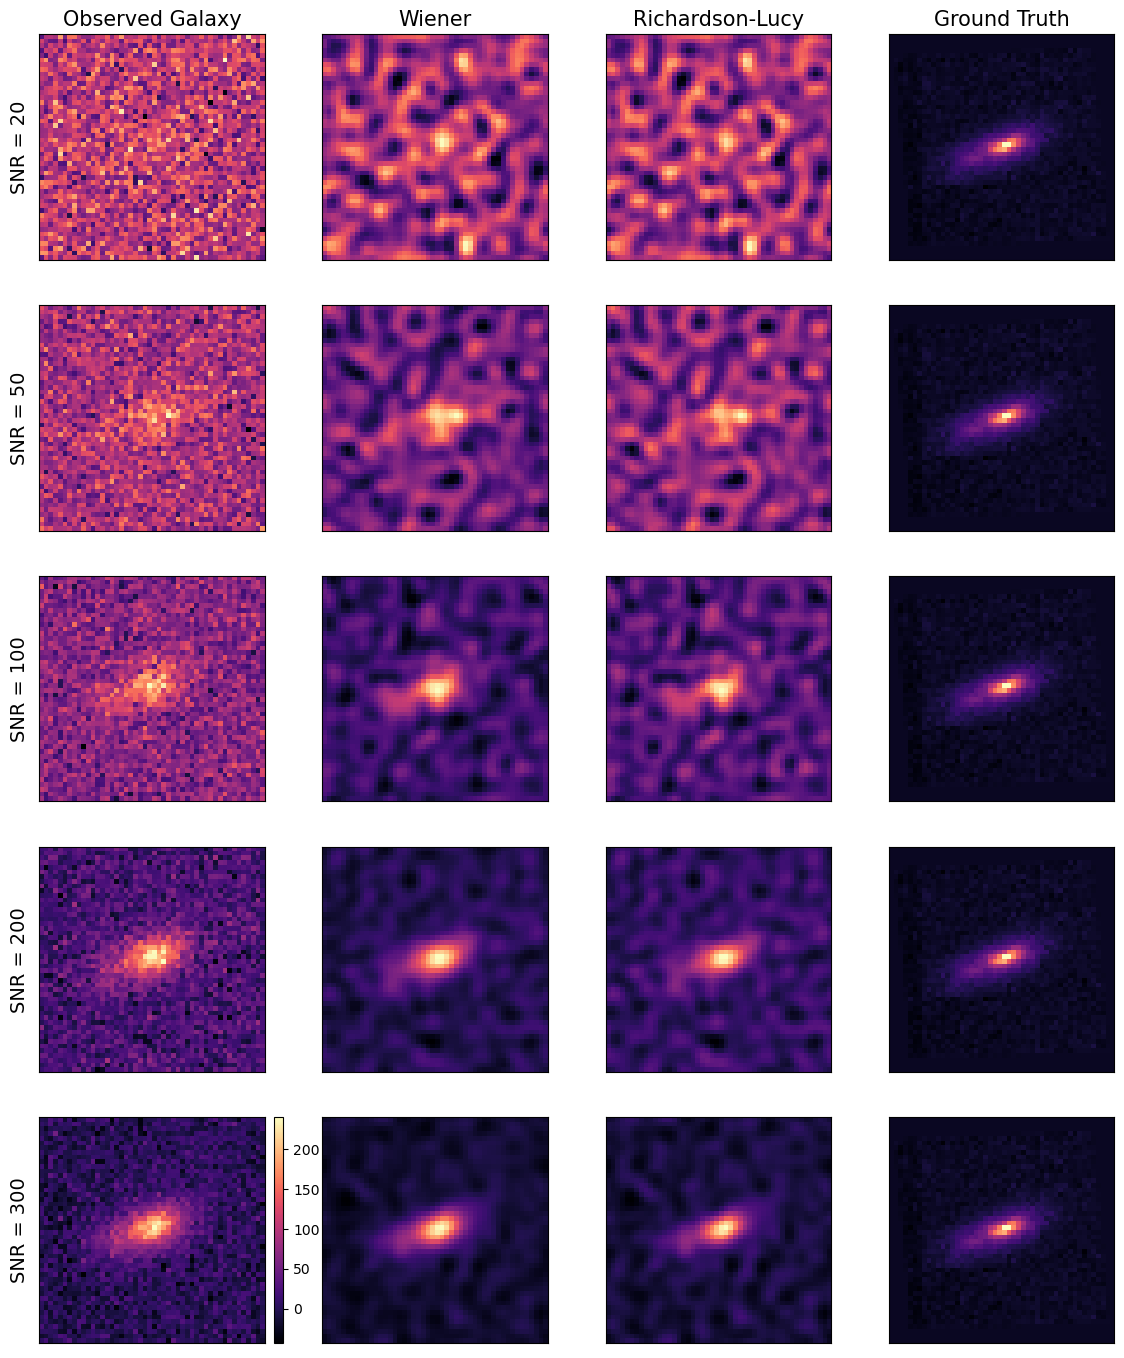

In [18]:
fig = plt.figure(figsize=(14, 17))
for idx, (x, y, snr) in enumerate(zip(gt_list, obs_list, snr_list)):
    ax1 = plt.subplot(5,4,idx*4+1)
    plt.imshow(y, cmap='magma')
    plt.ylabel(f'SNR = {snr}', fontsize=14)
    if idx == 4:
        cax = fig.add_axes([ax1.get_position().x1+6e-3, ax1.get_position().y0, 7e-3, ax1.get_position().height])
        cb = plt.colorbar(cax=cax)
        cb.set_label('Flux (ADU)', fontsize=14)
    ax1.set_xticks([])
    ax1.set_yticks([])
    if idx == 0:
        plt.title('Observed Galaxy', fontsize=15)
        
    
    ax2 = plt.subplot(5,4,idx*4+2)
    plt.imshow(wiener(y, psf, 0.1), cmap='magma')
    # ax2.set_title(f'SNR = {snr}', fontsize=14)
    # cax = fig.add_axes([ax2.get_position().x1+6e-3, ax2.get_position().y0, 7e-3, ax2.get_position().height])
    # cb = plt.colorbar(cax=cax)
    # cb.set_label('Flux (ADU)', fontsize=14)
    ax2.set_xticks([])
    ax2.set_yticks([])
    if idx == 0:
        plt.title('Wiener', fontsize=15)
        
    ax3 = plt.subplot(5,4,idx*4+3)
    plt.imshow(richardson_lucy(y, psf, sky_level_pixel, 20), cmap='magma')
    # ax2.set_title(f'SNR = {snr}', fontsize=14)
    # cax = fig.add_axes([ax2.get_position().x1+6e-3, ax2.get_position().y0, 7e-3, ax2.get_position().height])
    # cb = plt.colorbar(cax=cax)
    # cb.set_label('Flux (ADU)', fontsize=14)
    ax3.set_xticks([])
    ax3.set_yticks([])
    if idx == 0:
        plt.title('Richardson-Lucy', fontsize=15)
        
    ax4 = plt.subplot(5,4,idx*4+4)
    plt.imshow(x, cmap='magma')
    # ax2.set_title(f'SNR = {snr}', fontsize=14)
    # cax = fig.add_axes([ax2.get_position().x1+6e-3, ax2.get_position().y0, 7e-3, ax2.get_position().height])
    # cb = plt.colorbar(cax=cax)
    # cb.set_label('Flux (ADU)', fontsize=14)
    ax4.set_xticks([])
    ax4.set_yticks([])
    if idx == 0:
        plt.title('Ground Truth', fontsize=15)